# 目标检测数据集（皮卡丘）

在目标检测领域并没有类似 MNIST 那样的小数据集方便我们快速测试模型，为此我们合成了一个小的人工数据集。我们首先使用一个开源的皮卡丘 3D 模型生成了 1000 张不同角度和大小的皮卡丘图像。然后我们收集了一系列背景图像，并在每张图的随机位置放置一张皮卡丘图像。我们使用 MXNet 提供的[tools/im2rec.py](https://github.com/apache/incubator-mxnet/blob/master/tools/im2rec.py)来将图像打包成二进制 rec 文件。rec 格式是在 Gluon 开发出来之前 MXNet 常用的数据格式。目前 GluonCV 已经提供了更简单的，类似之前读取图像时的函数，从而可以省略打包图像的步骤。但由于这个工具包目前仍处在快速开发迭代中，这里我们仍使用 rec 格式。

## 下载数据集

打包好的数据集可以直接在网上下载。下载数据集的操作定义在`_download_pikachu`函数中。

In [1]:
import sys
sys.path.insert(0, '..')

%matplotlib inline
import gluonbook as gb
from mxnet import gluon, image
from mxnet.gluon import utils as gutils
import os

def _download_pikachu(data_dir):
    root_url = ('https://apache-mxnet.s3-accelerate.amazonaws.com/'
                'gluon/dataset/pikachu/')
    dataset = {'train.rec': 'e6bcb6ffba1ac04ff8a9b1115e650af56ee969c8',
               'train.idx': 'dcf7318b2602c06428b9988470c731621716c393',
               'val.rec': 'd6c33f799b4d058e82f2cb5bd9a976f69d72d520'}
    for k, v in dataset.items():
        gutils.download(root_url + k, os.path.join(data_dir, k), sha1_hash=v)

## 读取数据集

我们使用`image.ImageDetIter`来读取数据。这是一个针对目标检测的迭代器，函数中的“Det”表示 Detection。在读取训练图像时我们使用了随机裁剪。

In [2]:
# 本函数已保存在 gluonbook 包中方便以后使用。
def load_data_pikachu(batch_size, edge_size=256):
    # edge_size：输出图像的宽和高。
    data_dir = '../data/pikachu'
    _download_pikachu(data_dir)
    train_iter = image.ImageDetIter(
        path_imgrec=os.path.join(data_dir, 'train.rec'),
        # 每张图像在 rec 中的位置，使用随机顺序时需要。
        path_imgidx=os.path.join(data_dir, 'train.idx'),
        batch_size=batch_size,
        data_shape=(3, edge_size, edge_size),  # 输出图像形状。
        shuffle=True,  # 用随机顺序访问。
        rand_crop=1,  # 一定使用随机裁剪。
        min_object_covered=0.95,  # 裁剪出的图像至少覆盖每个目标 95% 的区域。
        max_attempts=200)  # 最多尝试 200 次随机裁剪。如果失败则不进行裁剪。
    val_iter = image.ImageDetIter(  # 测试图像则去除了随机访问和随机裁剪。
        path_imgrec=os.path.join(data_dir, 'val.rec'),
        batch_size=batch_size,
        data_shape=(3, edge_size, edge_size),
        shuffle=False)
    return train_iter, val_iter

batch_size, edge_size = 32, 256
train_iter, _ = load_data_pikachu(batch_size, edge_size)

下面我们读取一个批量。

In [3]:
batch = train_iter.next()
batch.data[0].shape, batch.label[0].shape

((32, 3, 256, 256), (32, 1, 5))

可以看到图像的形状跟之前图像分类时一样，但标签的形状则是（批量大小，每张图像中最大边界框数，5）。每个边界框由长度为 5 的数组表示。数组中的第一个元素是其对应目标的标号，当其数值为`-1`时表示非法，仅做填充使用。数组后面的 4 个元素表示边界框位置。这里使用的数据相对简单，每张图像只有一个边界框，而实际使用的目标检测数据集中每张图像可能会有多个边界框。由于我们要求每张图像有相同数量的边界框以便多张图像可以放在一个批量里高效处理，所以我们会使用一个最大边界框数。对于目标数量偏少的图像，则使用若干个非法边界框进行填充，使图像的边界框数量与最大边界框数保持一致。

## 图示数据

我们画出几张图像和其对应的边界框。可以看到皮卡丘的角度、大小和位置在每张图像都不一样。当然，这是一个简单的人工数据集，目标和背景的区别较大。实际中遇到的数据集通常会复杂很多。

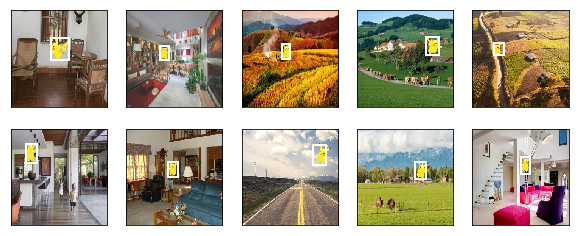

In [4]:
imgs = (batch.data[0][0:10].transpose((0, 2, 3, 1))) / 255
axes = gb.show_images(imgs, 2, 5).flatten()
for ax, label in zip(axes, batch.label[0][0:10]):
    gb.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])

## 小结

* 目标检测的数据读取跟图像分类的数据读取类似，但引入了边界框后导致标签形状和图像增强均有所不同。

## 练习

* 了解下`image.ImageDetIter`和`image.CreateDetAugmenter`这两个类的构造函数参数。

## 扫码直达[讨论区](https://discuss.gluon.ai/t/topic/7022)

![](../img/qr_object-detection-dataset.svg)